# Modeling and Simulation in Python

Richard Gao


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from matplotlib import patches
import math

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x_earth=r_0,
             y_earth=0 * m,
             vx_earth=0 * m / s,
             vy_earth=-30330 * m / s,
             x_asteroid=145e9 * m,
             y_asteroid=0 * m,
             vx_asteroid = -15.87e3 * m / s,
             vy_asteroid = 0 * m / s)

,values
x_earth,147000000000.0 meter
y_earth,0 meter
vx_earth,0.0 meter / second
vy_earth,-30330.0 meter / second
x_asteroid,145000000000.0 meter
y_asteroid,0 meter
vx_asteroid,-15870.0 meter / second
vy_asteroid,0.0 meter / second


In [4]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m_sun=1.989e30 * kg,
                m_earth=5.972e24 * kg,
                m_asteroid=3.2e9 * kg,
                r_final=r_sun + r_earth,
                t_0=0 * s,
                t_end=1 * UNITS.year)

,values
init,x_earth 147000000000.0 meter y_earth...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_sun,1.989e+30 kilogram
m_earth,5.972e+24 kilogram
m_asteroid,3200000000.0 kilogram
r_final,701879000.0 meter
t_0,0 second
t_end,1 year


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)
    
    displacement = Vector(x_earth, y_earth)
    
    force = G * m_sun * m_earth / displacement.mag**2

    return displacement.hat() * force 

In [6]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [7]:
def force_on_asteroid(state, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)
    
    displacement_s_e = Vector(x_earth, y_earth)
    displacement_s_a = Vector(x_asteroid, y_asteroid)
    
    # Get distance between earth and asteroid
    displacement_e_a = (displacement_s_e - displacement_s_a)
    
    force_sun = displacement_s_a.hat() * (G * m_sun * m_asteroid / displacement_s_a.mag**2)
    force_earth = displacement_e_a.hat() * (G * m_earth * m_asteroid / displacement_e_a.mag**2)
    
    return force_sun + force_earth

In [8]:
# The slope function

def slope_func(state, t, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)    

    force_earth = -universal_gravitation(state, system)
    
    dvxdt_earth = force_earth.x / m_earth
    dvydt_earth = force_earth.y / m_earth
    
    force_asteroid = -force_on_asteroid(state, system)
    
    dvxdt_asteroid = force_asteroid.x / m_asteroid
    dvydt_asteroid = force_asteroid.y / m_asteroid
    
    return vx_earth, vy_earth, dvxdt_earth, dvydt_earth, vx_asteroid, vy_asteroid, dvxdt_asteroid, dvydt_asteroid 

In [9]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>,
 <Quantity(-15870.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-0.006413357921070153, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [10]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day)

In [11]:
details

,values
sol,None
t_events,[]
nfev,2864
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [12]:
results.tail()

,x_earth,y_earth,vx_earth,vy_earth,x_asteroid,y_asteroid,vx_asteroid,vy_asteroid
2.552575e+07,4.754556e+10,1.410539e+11,28215.000434,-10066.595015,5.797877e+14,-7.755583e+13,2.641987e+07,-3.534079e+06
2.725375e+07,9.247644e+10,1.155671e+11,23247.959523,-19158.924901,6.254412e+14,-8.366272e+13,2.641987e+07,-3.534079e+06
2.898175e+07,1.262088e+11,7.611104e+10,15376.272545,-26053.142983,6.710948e+14,-8.976961e+13,2.641987e+07,-3.534079e+06
3.070975e+07,1.444768e+11,2.734162e+10,5536.493981,-29811.406923,7.167483e+14,-9.587649e+13,2.641987e+07,-3.534079e+06
3.155693e+07,1.469833e+11,1.803356e+09,365.407105,-30328.425354,7.391306e+14,-9.887047e+13,2.641987e+07,-3.534079e+06


In [13]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [14]:
# Scaling the distance to million km

x_earth = results.x_earth / 1e9;
y_earth = results.y_earth / 1e9;

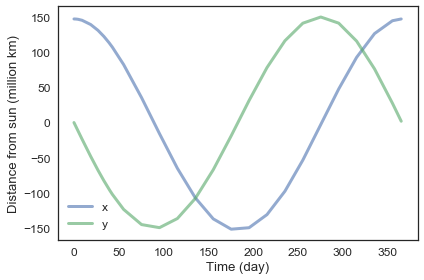

In [15]:
plot(x_earth, label='x')
plot(y_earth, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [21]:
#Scaling the distance to million km

x_asteroid = results.x_asteroid / 1e9;
y_asteroid = results.y_asteroid / 1e9;

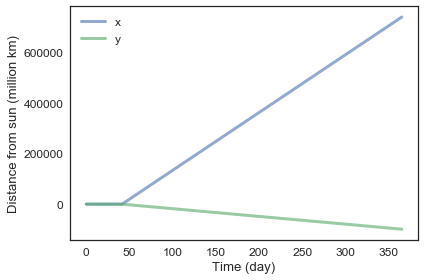

In [22]:
plot(x_asteroid, label='x')
plot(y_asteroid, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

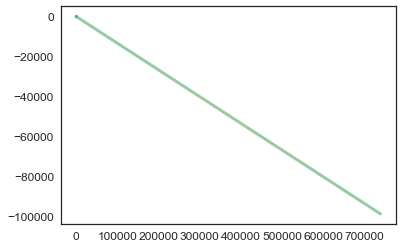

In [23]:
# And plotting

plot(x_earth, y_earth, label='earth')
plot(x_asteroid, y_asteroid, label='asteroid')

# # Plot sun as a circle with realistic radius
# ax = plt.gca()
# circle = Circle((0,0), radius=.695, color='orange')
# elements = [circle]
# ax.add_patch(circle)

# decorate(xlabel='x (million km)',
#          ylabel='y (million km)',
#          loc='upper center')

# # Plot with equal aspect ratio
# ax.set_aspect('equal')